In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('diabetes.csv')

#train test split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.25)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 465 to 155
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               576 non-null    int64  
 1   Glucose                   576 non-null    int64  
 2   BloodPressure             576 non-null    int64  
 3   SkinThickness             576 non-null    int64  
 4   Insulin                   576 non-null    int64  
 5   BMI                       576 non-null    float64
 6   DiabetesPedigreeFunction  576 non-null    float64
 7   Age                       576 non-null    int64  
 8   Outcome                   576 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 45.0 KB


In [9]:
df_train.iloc[:,:-1].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,3.866319,121.684028,69.036458,20.944444,84.375000,32.051389,0.474882,33.687500
std,3.433519,32.873155,19.290287,16.101538,120.147931,7.905478,0.327377,11.895907
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.400000,0.245750,24.000000
50%,3.000000,118.000000,72.000000,23.000000,39.000000,32.400000,0.370000,30.000000
75%,6.000000,143.000000,80.000000,33.000000,132.750000,36.600000,0.637750,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,59.400000,2.420000,81.000000


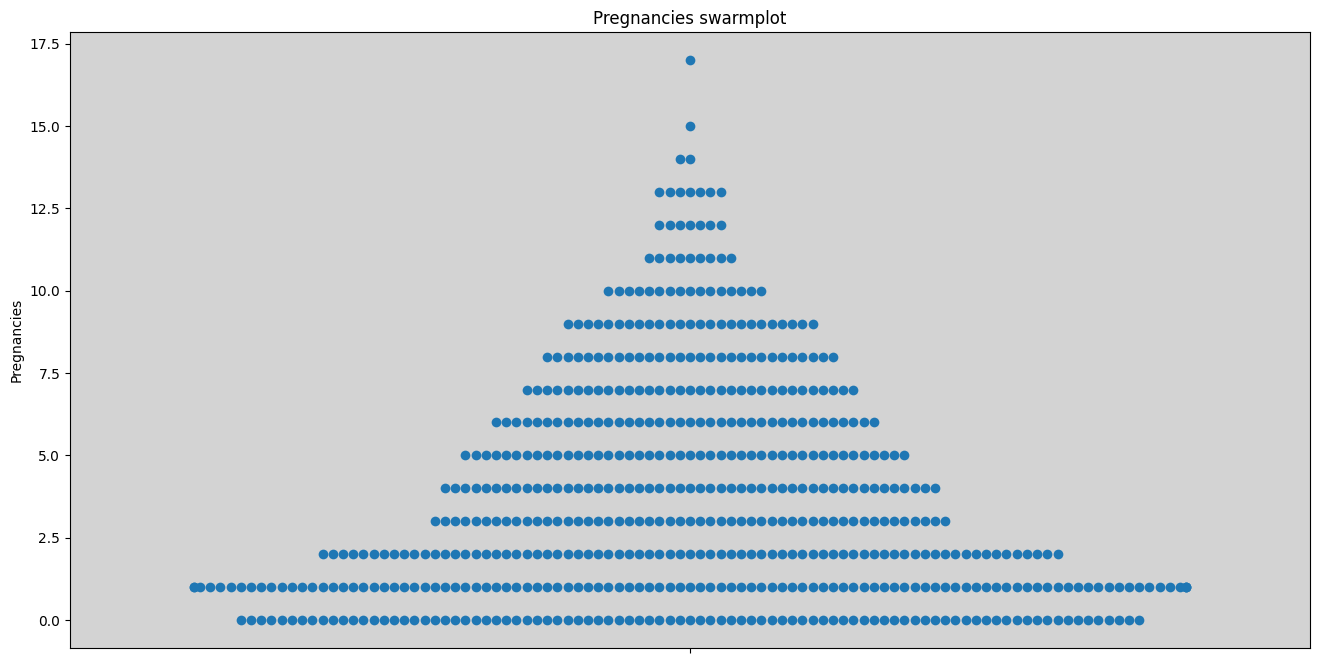

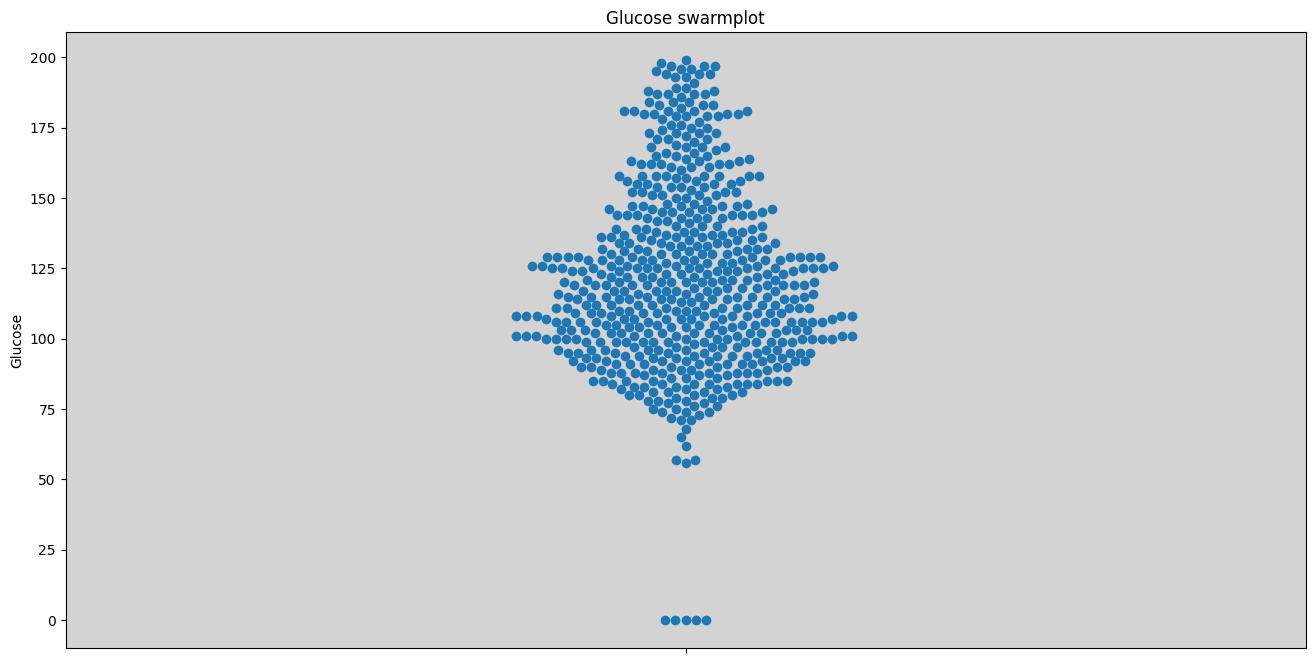

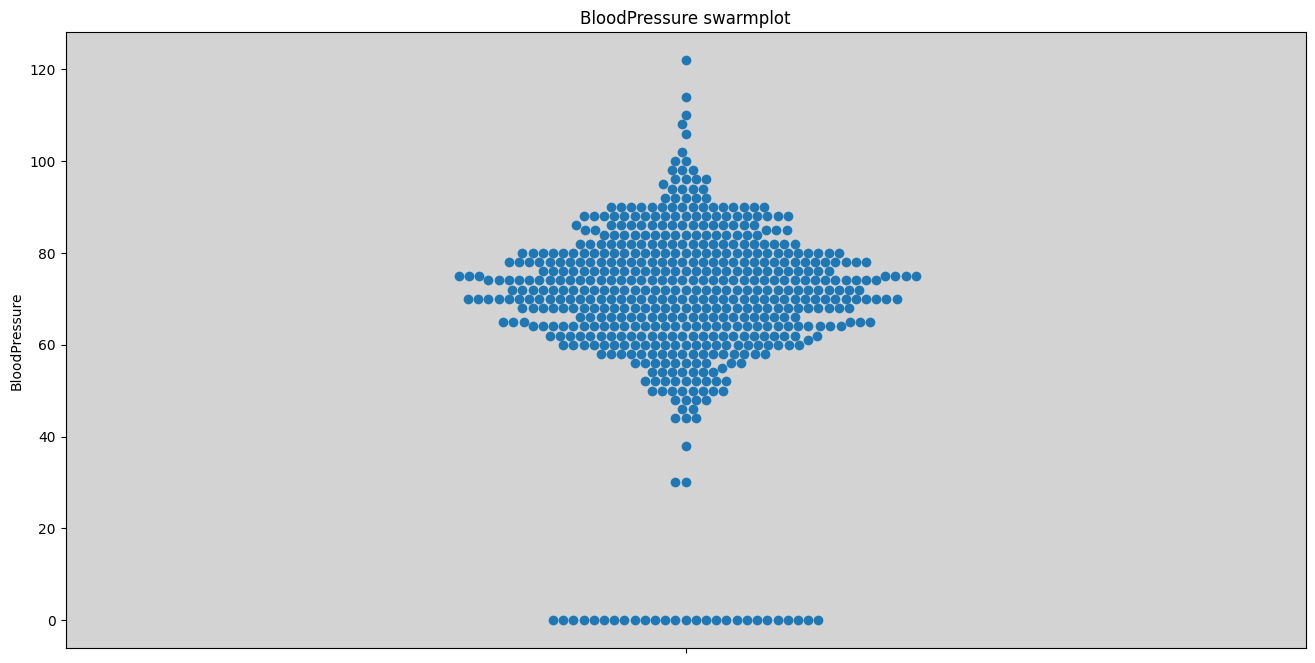

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


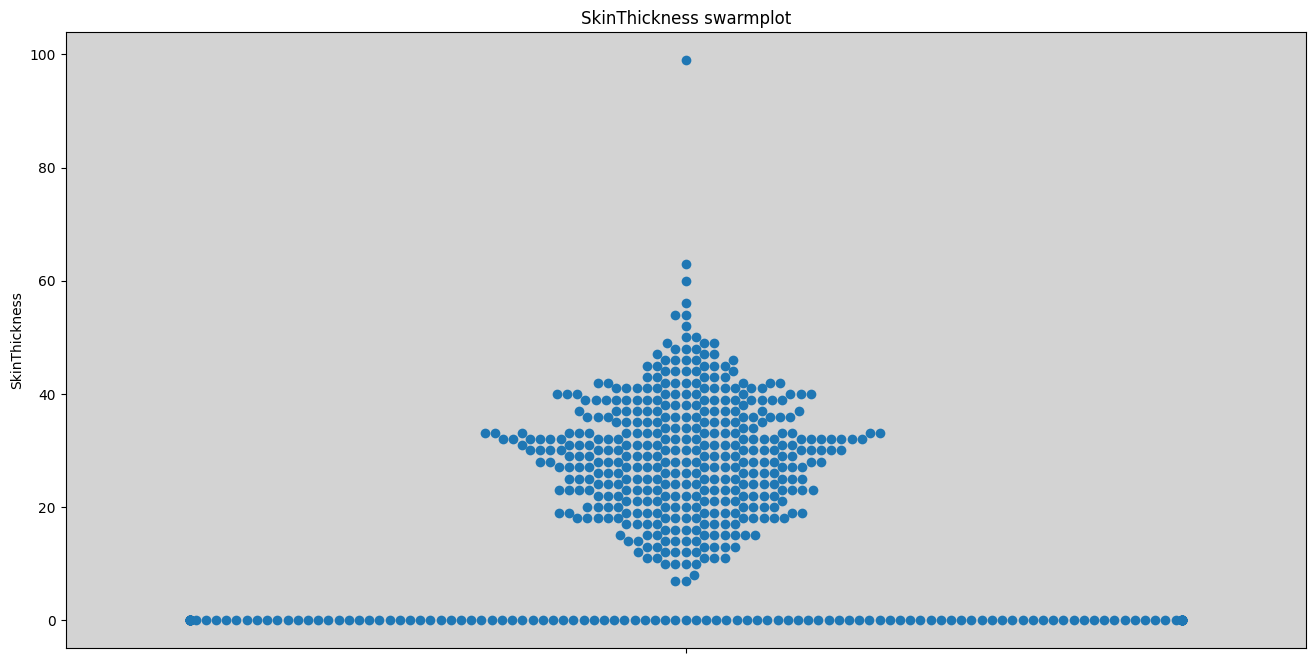

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


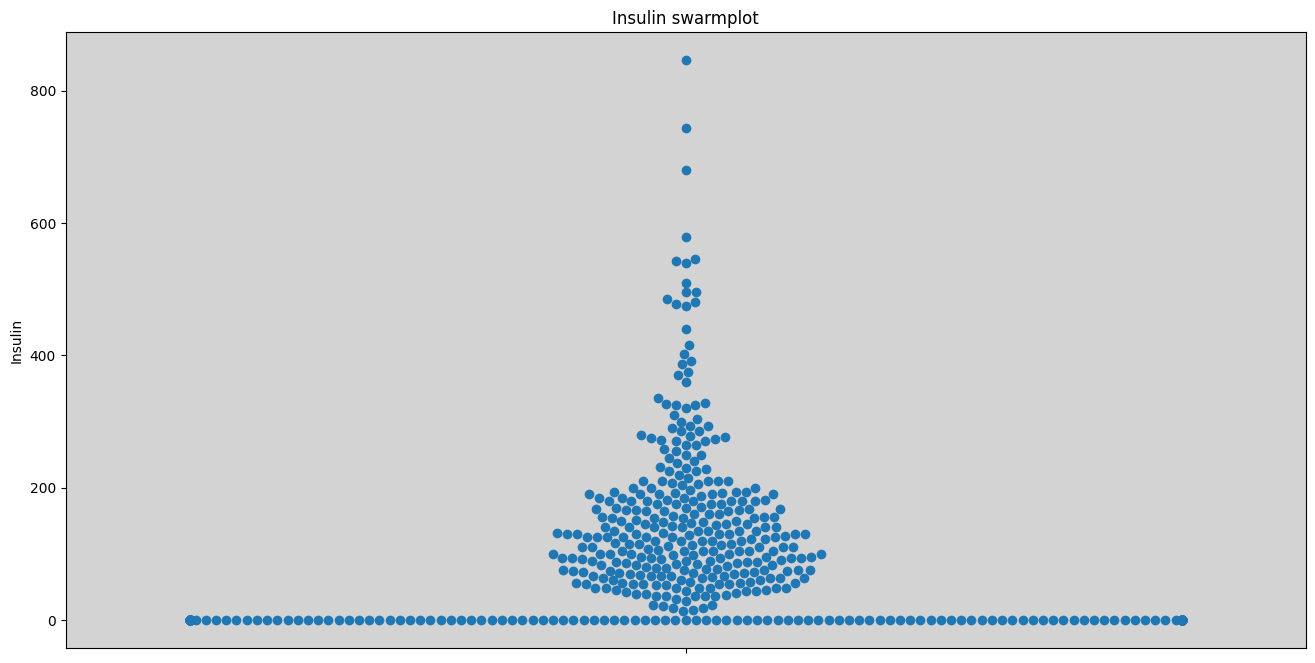

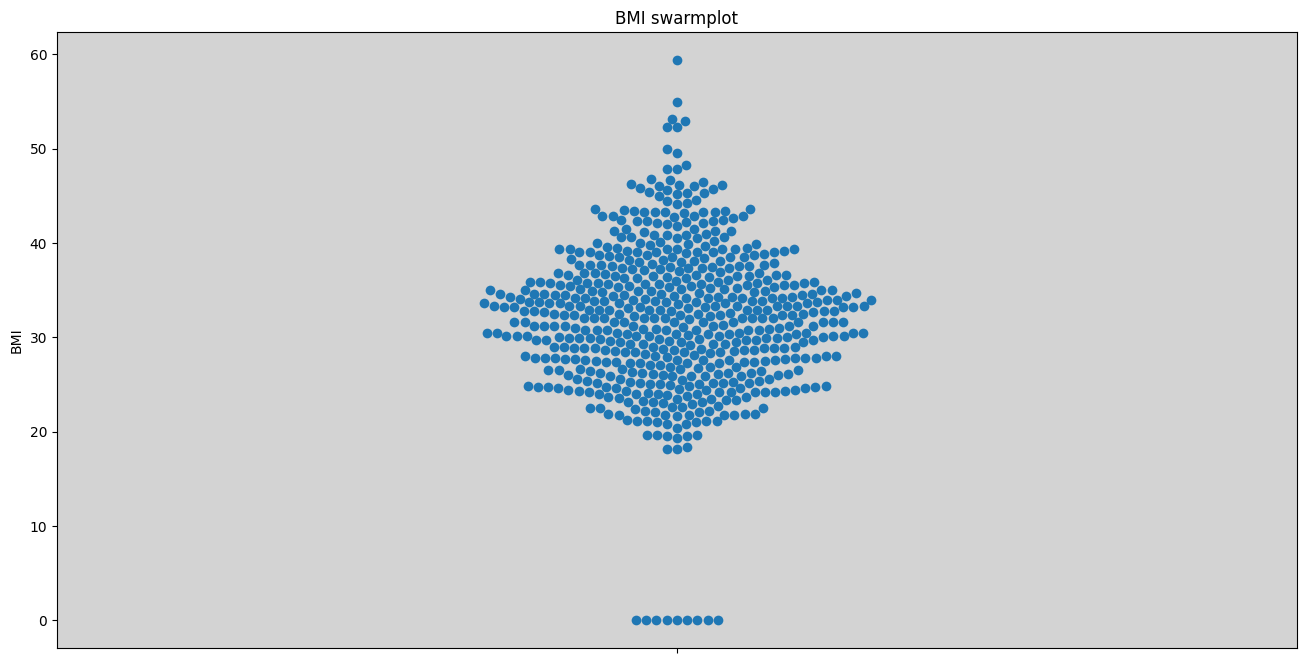

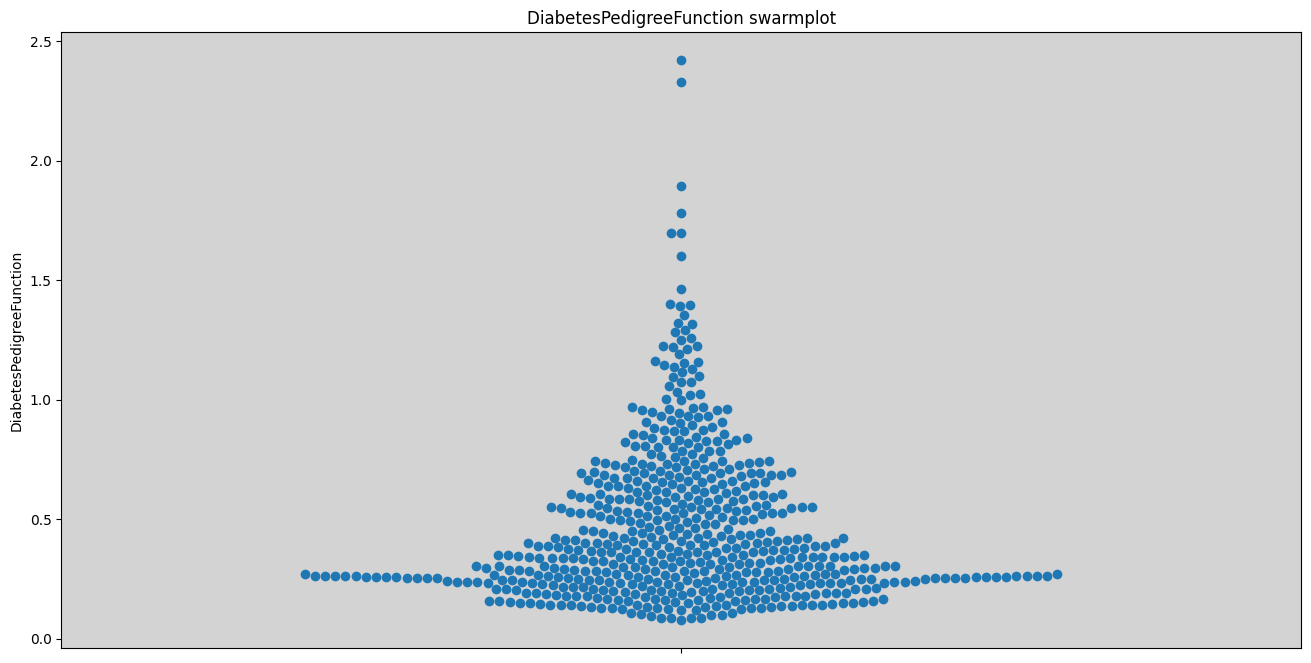

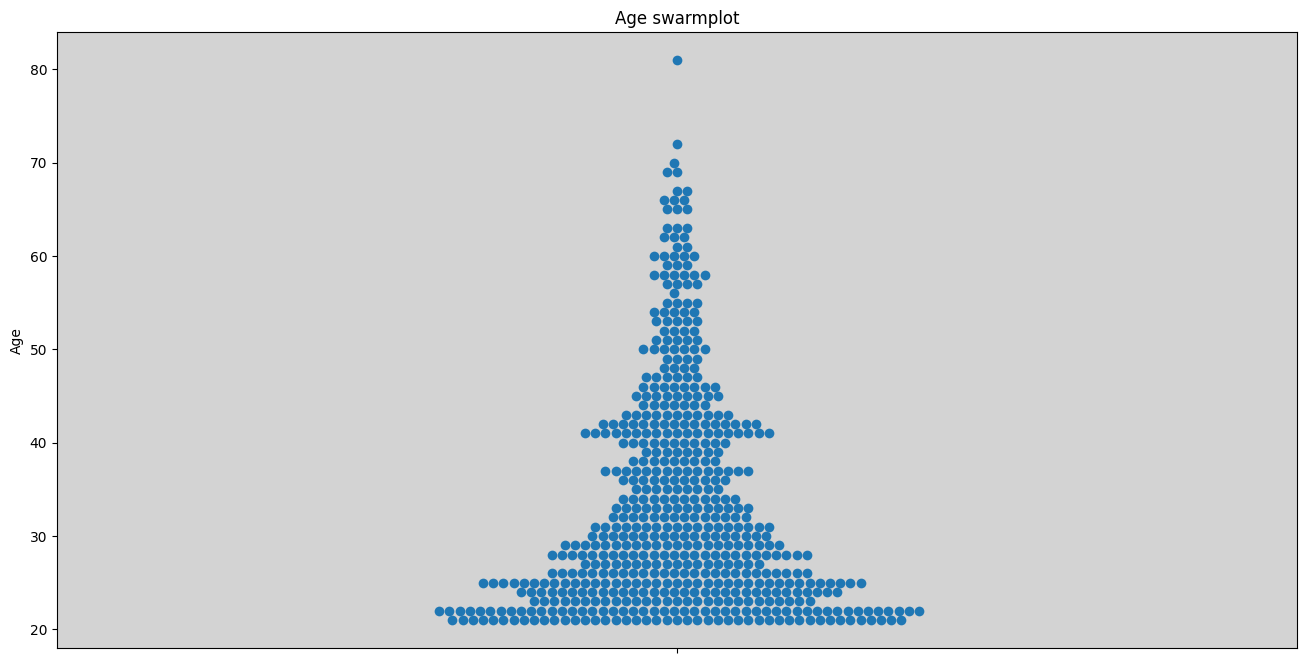

In [10]:
for column in df_train.columns[:-1]:
  plt.figure(figsize=(16,8))
  plt.axes().set_facecolor("lightgray")
  sns.swarmplot(y = column, data=df_train, size = 7)
  plt.title(f'{column} swarmplot')
  plt.show()

In [11]:
#there are unreasonable 0 values, that should be replaced with np.nans.
#columns with such zeros will be stored in list 'zeros to fix'
zeros_to_fix = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df_train[zeros_to_fix] = df_train[zeros_to_fix].replace(0, np.nan)

In [12]:
df_train.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                27
SkinThickness               167
Insulin                     273
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [14]:
#missing values in columns 'Glucose','BloodPressure','BMI' will be replaced with median, as there are not many missing values
from sklearn.impute import SimpleImputer
median_imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
median_imputer.fit(df_train[['Glucose','BloodPressure','BMI']])
df_train[['Glucose','BloodPressure','BMI']] = median_imputer.transform(df_train[['Glucose','BloodPressure','BMI']])

In [23]:
#there are a lot of missing values in columns SkinThickness (28%) and Insulin (47%)
#we will try to replace those values by predictiing them - predicitons should do better then simple mean/median replacement

#SkinThickness missing values replacement:
#lets create set containing no missing values in SkinThickness column. Insulin column is dropped as it contains many missing values
#outcome column is dropped as it is Y variable, so it will not be available in test set in which missing values replacement will be performed using the same model
#this set is created to train the model to predict missing values in SkinThickness column

df_skin = df_train[~df_train.SkinThickness.isna()].drop(columns=(['Insulin','Outcome']))
df_skin_x = df_skin.loc[:, df_skin.columns != 'SkinThickness'].values
df_skin_y = df_skin[['SkinThickness']].values

In [24]:
#feature scailing
from sklearn.preprocessing import StandardScaler
sc_skin_x = StandardScaler()
df_skin_x = sc_skin_x.fit_transform(df_skin_x)

sc_skin_y = StandardScaler()
df_skin_y = sc_skin_y.fit_transform(df_skin_y)

In [27]:
#SVR model will be used to predict missing values in SkinThickness column
from sklearn.svm import SVR
from sklearn.metrics import r2_score

regressor_skin = SVR(kernel = 'rbf', gamma = 0.01)
regressor_skin.fit(df_skin_x, df_skin_y)
preds = regressor_skin.predict(df_skin_x)

#r2 score on training set
print(r2_score(df_skin_y, preds))

#cross validation test
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor_skin, X = df_skin_x, y = df_skin_y, cv = 10)
accuracies.mean()

#moderate r2 score, but better then mean replacement or dropping the SkinThickness column

0.4348378892972343


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.41852404916578684

In [28]:
#lets predict SkinThickness missing values and do the replacement
df_skin_na = df_train[df_train.SkinThickness.isna()].drop(columns=(['Insulin','Outcome','SkinThickness'])).values

#feature scailing done by using only tranform method from train set to avoid data leakage
df_skin_na = sc_skin_x.transform(df_skin_na)
preds_skin = regressor_skin.predict(df_skin_na)

#inversing the feature scailing, so the values can be put in df
preds_skin = sc_skin_y.inverse_transform(preds_skin.reshape(-1,1))
df_train.loc[df_train.SkinThickness.isnull(), 'SkinThickness'] = preds_skin

In [ ]:
#now let's replace missing values in Insulin column the same way

In [29]:
df_insulin = df_train[~df_train.Insulin.isna()].drop(columns=(['SkinThickness','Outcome']))
df_insulin_x = df_insulin.loc[:, df_insulin.columns != 'Insulin'].values
df_insulin_y = df_insulin[['Insulin']].values

sc_insulin_x = StandardScaler()
df_insulin_x = sc_insulin_x.fit_transform(df_insulin_x)

sc_insulin_y = StandardScaler()
df_insulin_y = sc_insulin_y.fit_transform(df_insulin_y)

regressor_insulin = SVR(kernel = 'rbf', gamma = 0.1)
regressor_insulin.fit(df_insulin_x, df_insulin_y)
preds = regressor_insulin.predict(df_insulin_x)

print(r2_score(df_insulin_y, preds))

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor_insulin, X = df_insulin_x, y = df_insulin_y, cv = 10)
print(accuracies.mean())

df_insulin_na = df_train[df_train.Insulin.isna()].drop(columns=(['Insulin','Outcome','SkinThickness'])).values
df_insulin_na = sc_insulin_x.transform(df_insulin_na)

preds_insulin = regressor_insulin.predict(df_insulin_na)
preds_insulin = sc_insulin_y.inverse_transform(preds_insulin.reshape(-1,1))
df_train.loc[df_train.Insulin.isnull(), 'Insulin'] = preds_insulin

0.39774929445664753
0.20034080288034714


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [30]:
df_train.isna().sum() #no missing values now

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

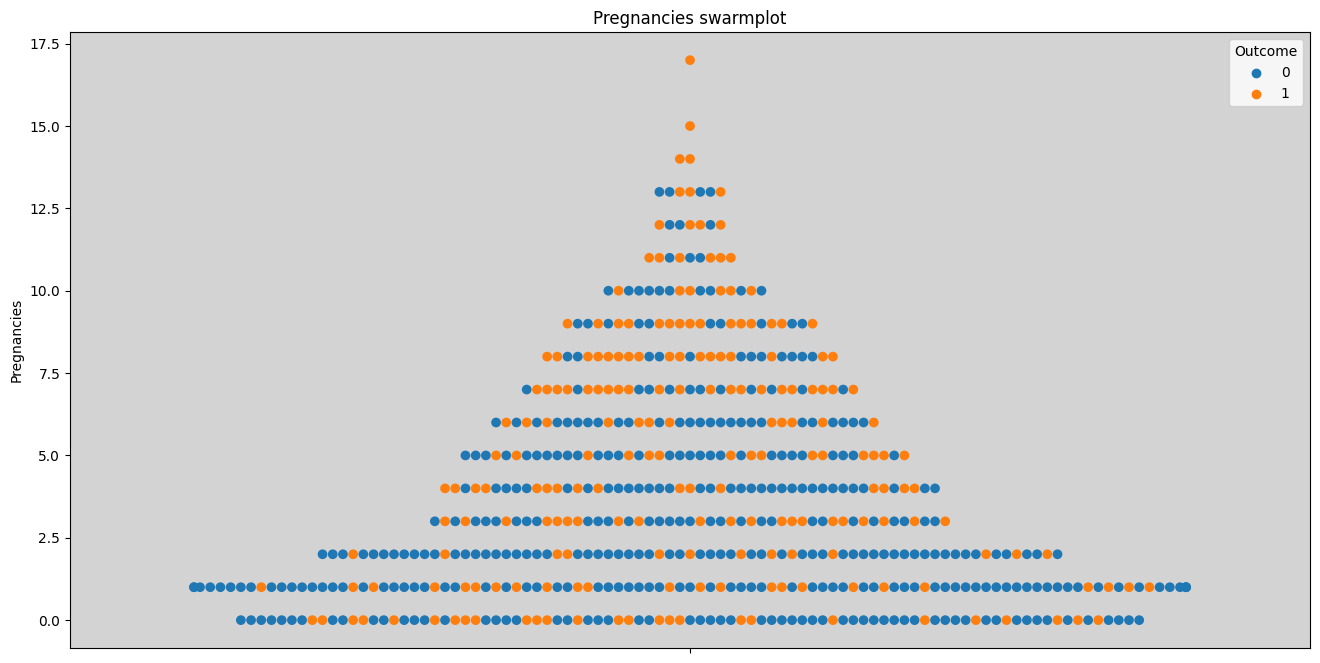

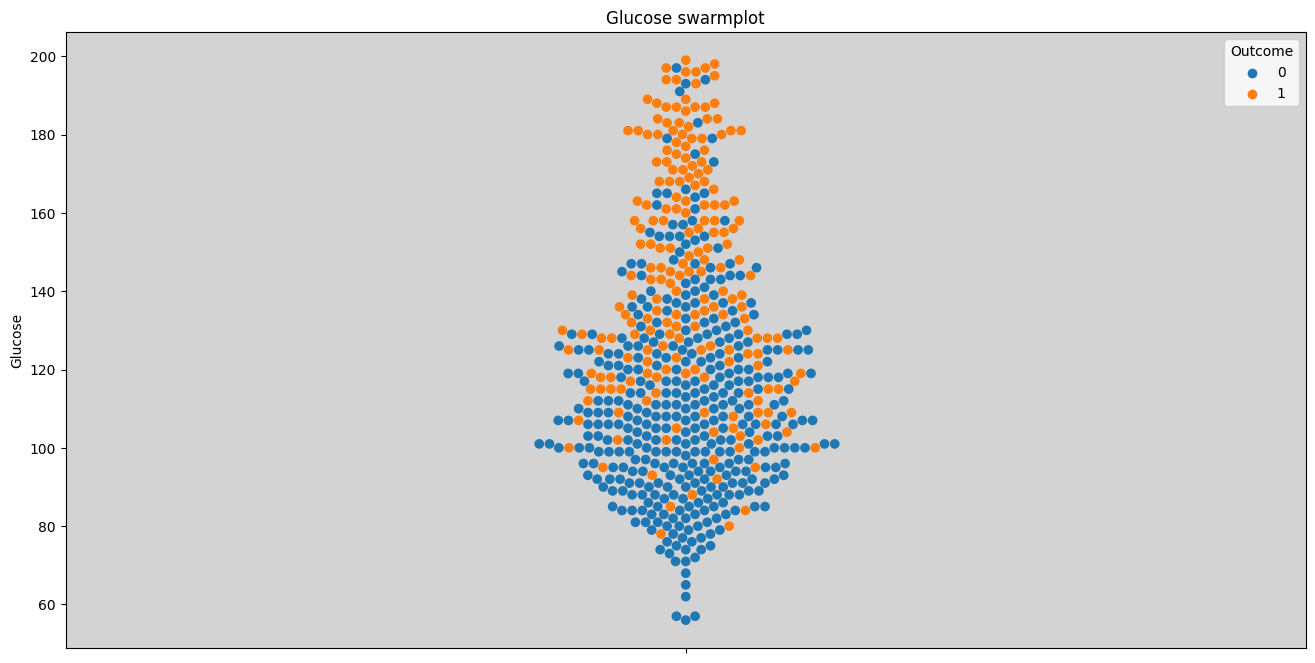

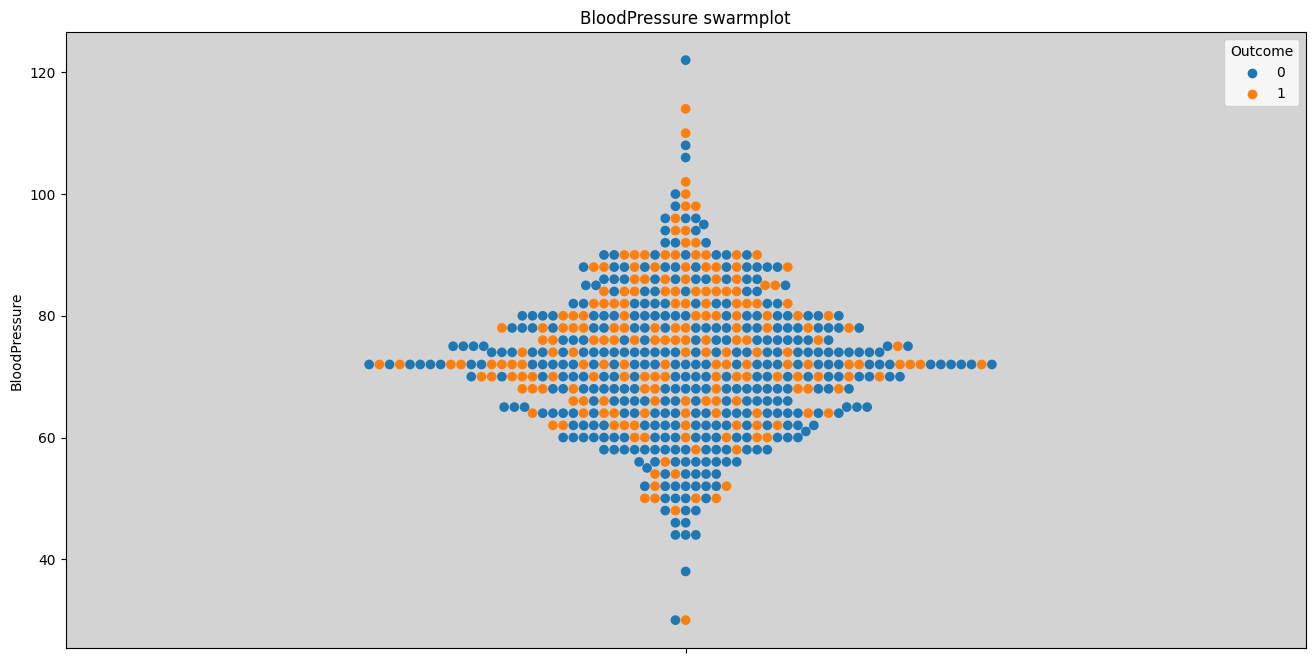

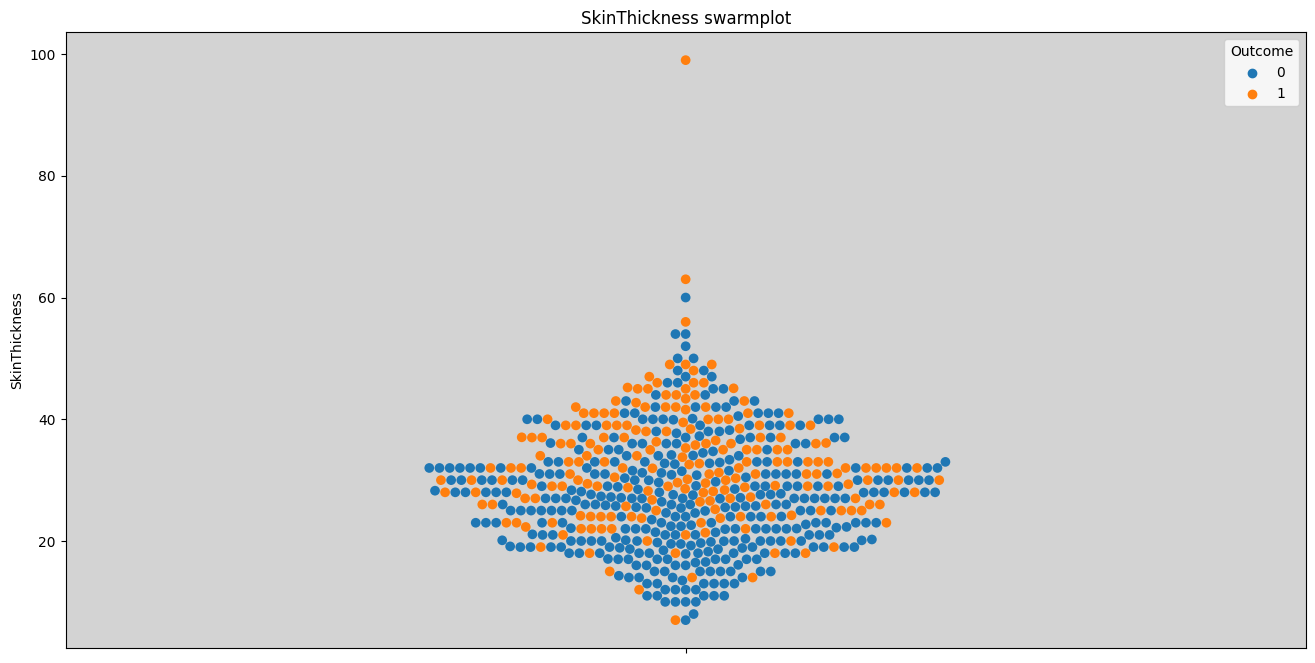

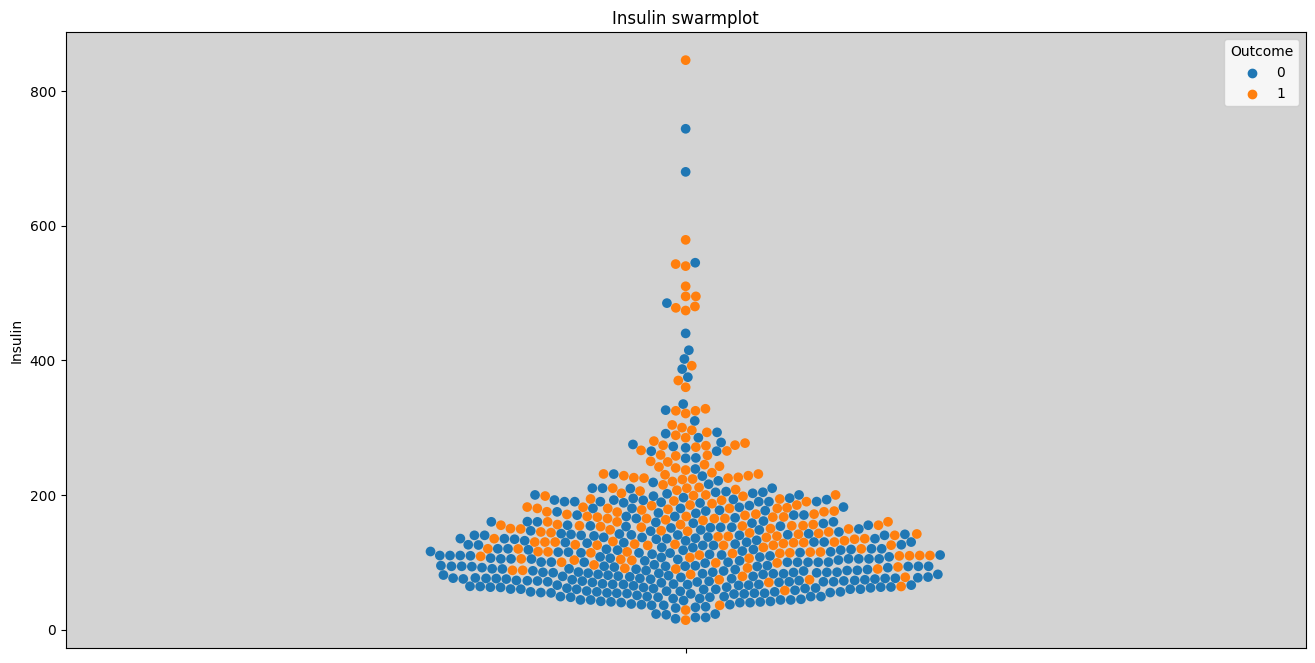

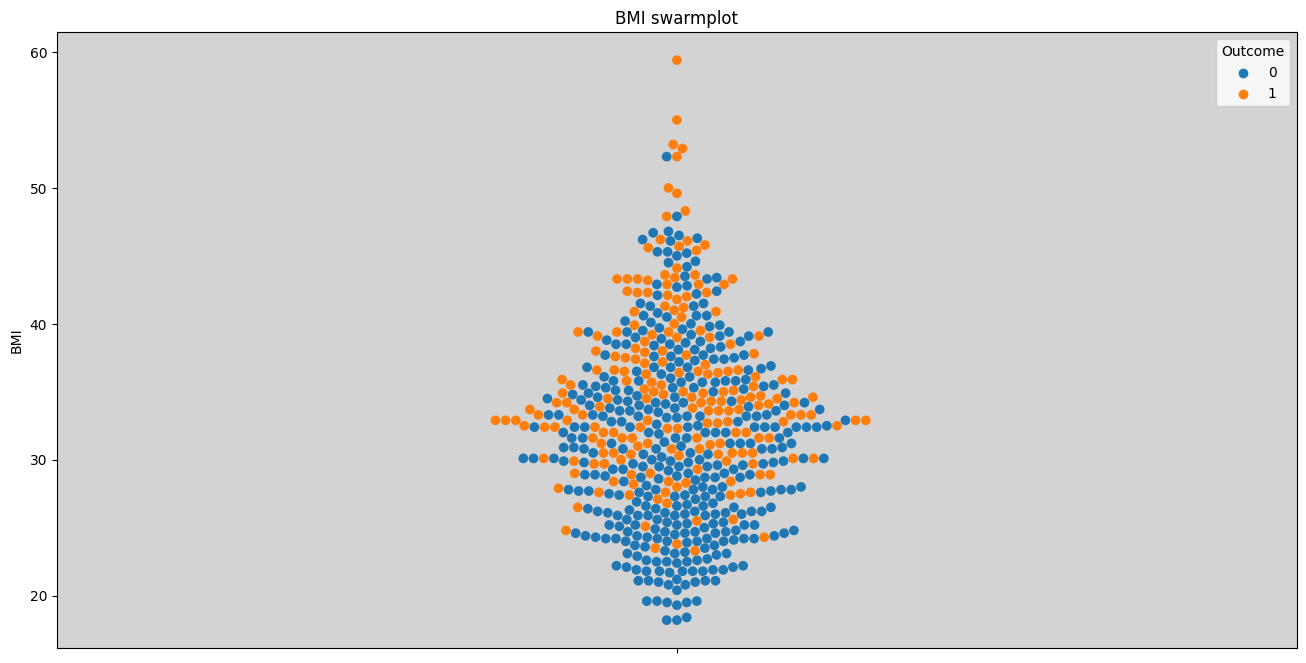

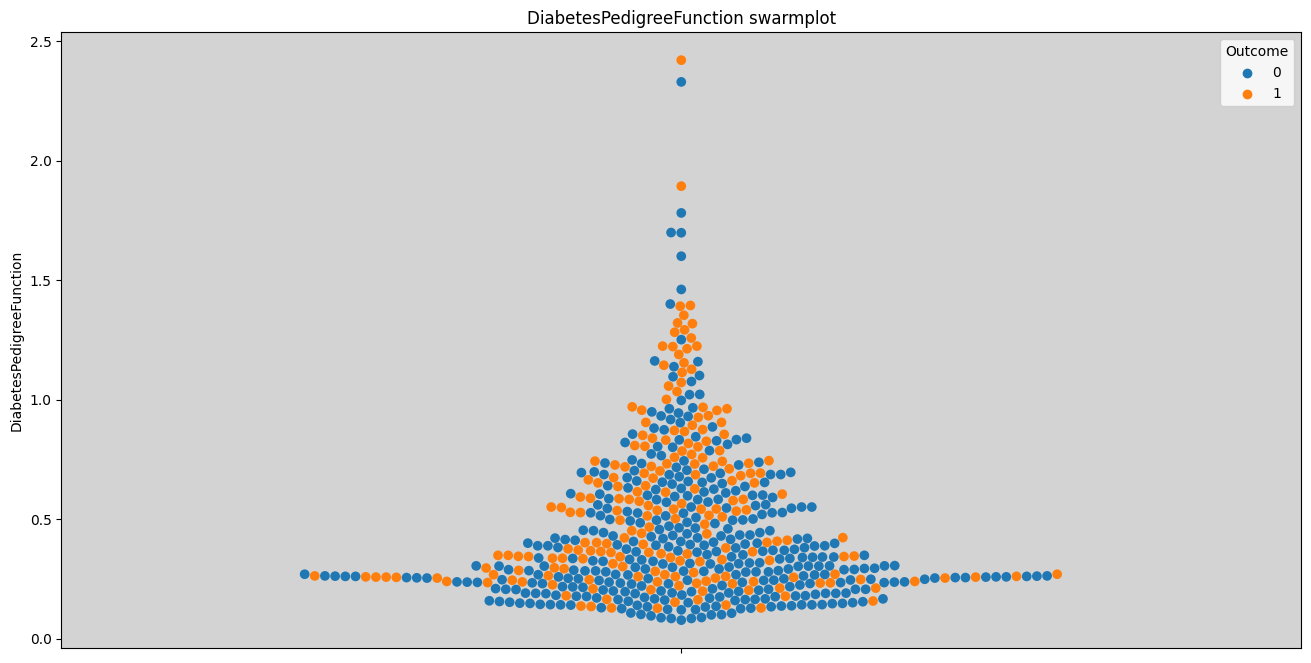

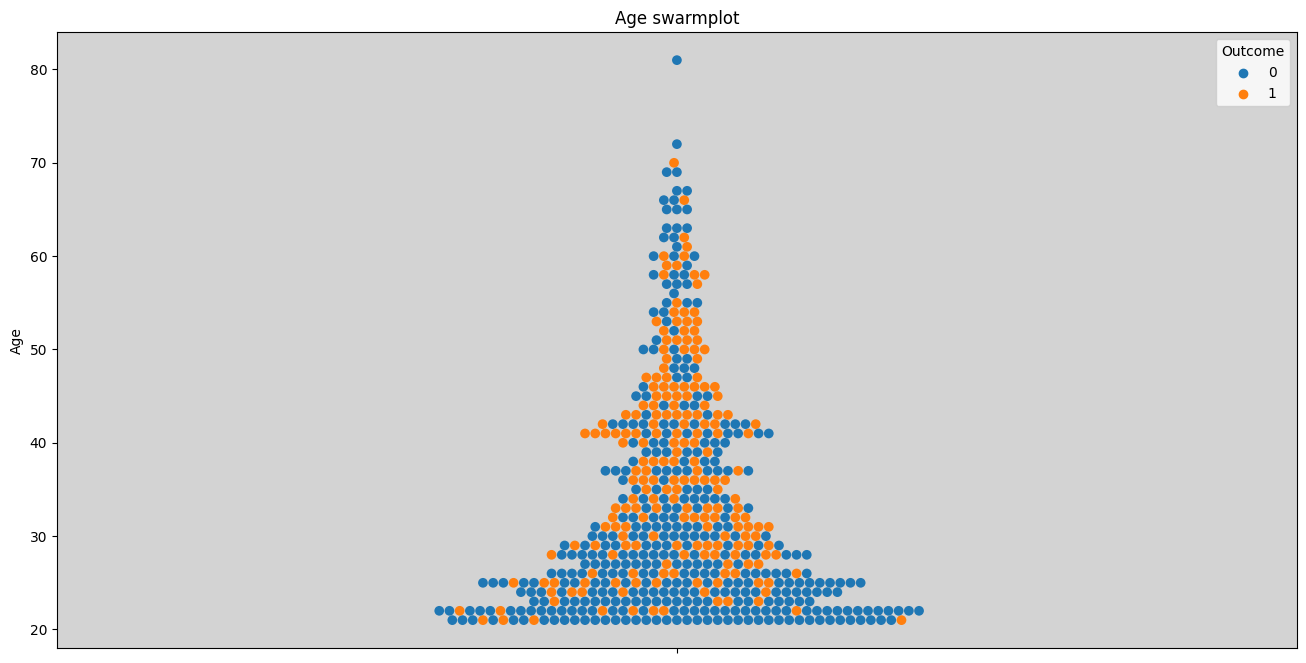

In [31]:
#train test visualization
for column in df_train.columns[:-1]:
  plt.figure(figsize=(16,8))
  plt.axes().set_facecolor("lightgray")
  sns.swarmplot(y = column, data=df_train, hue = 'Outcome', size = 7)
  plt.title(f'{column} swarmplot')
  plt.show()

In [33]:
#lets take a look at the possible outliers
#pregnancies seem to be ok, given patients age
#all patients here are females of Pima Indian heritage, where borning many children may be expected
df_train[df_train.Pregnancies > 10]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
215,12,151.0,70.0,40.000000,271.000000,41.8,0.742,38,1
88,15,136.0,70.0,32.000000,110.000000,37.1,0.153,43,1
323,13,152.0,90.0,33.000000,29.000000,26.8,0.731,43,1
559,11,85.0,74.0,26.445220,87.707374,30.1,0.300,35,0
72,13,126.0,90.0,38.226904,137.945248,43.4,0.583,42,1
455,14,175.0,62.0,30.000000,148.169060,33.6,0.212,38,1
193,11,135.0,72.0,45.212394,146.890448,52.3,0.578,40,1
648,11,136.0,84.0,35.000000,130.000000,28.3,0.260,42,1
518,13,76.0,60.0,28.895649,121.707116,32.8,0.180,41,0
86,13,106.0,72.0,54.000000,119.363892,36.6,0.178,45,0


In [35]:
#SkinThickness value equal to 99 seems to be wrong. It is the only outlier in the train set
#also - patients with higher BMI have much lower SkinThickness
#finally such a value seems to be very unlikely. let's remove this patient from the df
df_train[df_train.SkinThickness > 90]

df_train = df_train[df_train.SkinThickness < 90]

In [36]:
#as the train test is ready - let's replace missing values in test set
df_test[zeros_to_fix] = df_test[zeros_to_fix].replace(0, np.nan)
df_test[['Glucose','BloodPressure','BMI']] = median_imputer.transform(df_test[['Glucose','BloodPressure','BMI']])

#SkinThickness
test_preds_skin = regressor_skin.predict(
    sc_skin_x.transform(df_test[df_test.SkinThickness.isna()].drop(columns =(['Insulin','Outcome','SkinThickness']))))

test_preds_skin = sc_skin_y.inverse_transform(test_preds_skin.reshape(-1,1))
df_test.loc[df_test.SkinThickness.isnull(), 'SkinThickness'] = test_preds_skin

#Insulin
test_preds_insulin = regressor_insulin.predict(
    sc_insulin_x.transform(df_test[df_test.Insulin.isna()].drop(columns =(['Insulin','Outcome','SkinThickness']))))

test_preds_insulin = sc_insulin_y.inverse_transform(test_preds_insulin.reshape(-1,1))
df_test.loc[df_test.Insulin.isnull(), 'Insulin'] = test_preds_insulin

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [37]:
#prediction of the Outcome value
X_train = df_train.iloc[:,:-1].values
Y_train = df_train.iloc[:,-1].values
X_test = df_test.iloc[:,:-1].values
Y_test = df_test.iloc[:,-1].values

#XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

classifier = XGBClassifier(max_depth = 1)
classifier.fit(X_train, Y_train)

preds = classifier.predict(X_train)
#accuracy on train set 83%, depth decreased to prevent overfitting
print(accuracy_score(Y_train, preds)) #83%

#accuracy on test set
preds = classifier.predict(X_test)
print(accuracy_score(Y_test, preds)) #72%

0.8347826086956521
0.7291666666666666


In [38]:
#random forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 128, criterion = 'entropy', max_depth = 3)
classifier.fit(X_train, Y_train)
preds = classifier.predict(X_train)
print(accuracy_score(Y_train, preds)) #80% on train set

preds = classifier.predict(X_test)
print(accuracy_score(Y_test, preds)) #75% on test set

0.7913043478260869
0.7552083333333334


In [39]:
#SVM model (requires feature scailing)
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', gamma = 0.01)
classifier.fit(X_train, Y_train)
preds = classifier.predict(X_train)
print(accuracy_score(Y_train, preds)) #78% on train set

preds = classifier.predict(X_test)
print(accuracy_score(Y_test, preds)) #74% on test set

0.7791304347826087
0.7395833333333334


In [40]:
#artificial neural network
import tensorflow as tf
ann = tf.keras.models.Sequential()

ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, Y_train, batch_size = 10, epochs = 100)

preds_train = ann.predict(X_train)
preds_train = (preds_train>0.5).astype(int)
print(accuracy_score(Y_train, preds_train)) #85% on train set

preds_test = ann.predict(X_test)
preds_test = (preds_test>0.5).astype(int)
print(accuracy_score(Y_test, preds_test)) #74% in test set

Epoch 1/100
58/58 [==============================] - 1s 2ms/step - loss: 0.6275 - accuracy: 0.6470
Epoch 2/100
58/58 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.6539
Epoch 3/100
58/58 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.6591
Epoch 4/100
58/58 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.6817
Epoch 5/100
58/58 [==============================] - 0s 2ms/step - loss: 0.5109 - accuracy: 0.7287
Epoch 6/100
58/58 [==============================] - 0s 2ms/step - loss: 0.5002 - accuracy: 0.7565
Epoch 7/100
58/58 [==============================] - 0s 2ms/step - loss: 0.4921 - accuracy: 0.7722
Epoch 8/100
58/58 [==============================] - 0s 2ms/step - loss: 0.4843 - accuracy: 0.7652
Epoch 9/100
58/58 [==============================] - 0s 2ms/step - loss: 0.4782 - accuracy: 0.7791
Epoch 10/100
58/58 [==============================] - 0s 2ms/step - loss: 0.4717 - accuracy: 0.7774
Epoch 11/

In [ ]:
#random forest with best test set accuracy: 75%
#n_estimators = 128, criterion = 'entropy', max_depth = 3